## Objectif du Projet

Ce projet vise à concevoir, optimiser et valider une stratégie d'allocation d'actifs multi-classe. L'idée centrale est de démontrer l'efficacité d'un processus de gestion de portefeuille dynamique, basé sur un rééquilibrage périodique et une évaluation rigoureuse de la performance historique.

L'objectif final est de construire un portefeuille robuste qui non seulement génère une performance attractive, mais reste également fidèle à une politique d'investissement prédéfinie, offrant ainsi un cadre de décision fiable et réaliste pour un gérant.

---

## Partie 1: Définition de l'Univers d'Investissement et Collecte des Données

In [1]:
import yfinance as yf
import pandas   as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot    as  plt
import seaborn as sns
import matplotlib.pyplot as plt
import  matplotlib.pyplot   as  plt
from    datetime    import  datetime
from scipy.optimize import minimize

In [2]:
sectors = {
    "Technologie": ["005930.KS", "AAPL", "AMZN", "CSCO", "FB", "GOOGL", "IMB", "INTC", "META", "MSFT","NVDA", "ORCL", "TSM"],
    "Finance-Banque": ["0939.HK", "1288.HK", "1299.HK", "1398.HK", "AXP", "BAC", "BARC.L", "BK", "BLK", "BRK.A","C", "CBA.AX", "GS", "HSBC", "JPM", "MS", "PNC", "USB", "WFC"],
    "Biens de consommation": ["ABI.BR", "BATS.L", "CL", "KMB", "KO", "MDLZ", "MO", "NESN.SW", "NKE", "OR.PA","PEP", "PG", "PM", "UL", "UN"],
    "Automobile": ["7201.T", "7267.T", "BMW.DE", "DAI.DE", "MBG.DE", "F", "FCAU", "GM", "HMC", "NSANY", "RACE", "STLA", "TM", "TSLA", "VOW3.DE", "VWAGY"],
    "Luxe": ["1913.HK", "BRBY.L", "CDI.PA", "CFR.SW", "EL", "KER.PA", "LULU", "LVMUY", "MC.PA", "MONC.MI","OR.PA", "PVH", "RL", "RMS.PA", "TIF", "TPR", "UHR.SW"]
    }

bonds = [ "VBTLX", "HYG", "BHYIX", "AGG", "LQD", "JNK", "TLT", "BND", "IEF", "SHY", "EMB", "MUB", "SCHZ", "VGIT", "VCSH"]

commodities = ["GLD", "WEAT", "DBC", "SLV", "PDBC", "USO", "DBA", "COPX", "JJG", "UGA", "BCI", "IAU", "DBE", "SGG", "NIB"]

def get_market_cap(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return info.get('marketCap', 0)
    except Exception as e:
        print(f"Erreur lors de la récupération de la marketCap pour {ticker}: {e}")
        return 0

def get_volume(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return info.get('averageVolume', 0)
    except Exception as e:
        print(f"Erreur lors de la récupération du volume pour {ticker}: {e}")
        return 0

def get_top_10_by_sector(sector_tickers, key_metric='marketCap'):
    tickers_with_metric = []
    for ticker in sector_tickers:
        if key_metric == 'marketCap':
            metric = get_market_cap(ticker)
        elif key_metric == 'volume':
            metric = get_volume(ticker)
        else:
            metric = 0

        if metric:
            tickers_with_metric.append((ticker, metric))

    tickers_with_metric.sort(key=lambda x: x[1], reverse=True)

    return [ticker for ticker, metric in tickers_with_metric[:10]]

for sector, tickers in sectors.items():
    sectors[sector] = get_top_10_by_sector(tickers, key_metric='marketCap')

bonds = get_top_10_by_sector(bonds, key_metric='volume')

commodities = get_top_10_by_sector(commodities, key_metric='volume')

print("sectors = {")
for sector, tickers in sectors.items():
    print(f'    "{sector}": {tickers},  # {sector}')
print("}")

print("\n# Obligations")
print(f'bonds = {bonds}')

print("\n# Commodités")
print(f'commodities = {commodities}')

sectors = {
    "Technologie": ['005930.KS', 'NVDA', 'MSFT', 'AAPL', 'GOOGL', 'AMZN', 'META', 'TSM', 'ORCL', 'CSCO'],  # Technologie
    "Finance-Banque": ['1398.HK', '1288.HK', '0939.HK', 'JPM', '1299.HK', 'BAC', 'CBA.AX', 'WFC', 'MS', 'HSBC'],  # Finance-Banque
    "Biens de consommation": ['PG', 'KO', 'PM', 'OR.PA', 'PEP', 'NESN.SW', 'UL', 'MO', 'NKE', 'ABI.BR'],  # Biens de consommation
    "Automobile": ['7267.T', 'TSLA', '7201.T', 'TM', 'RACE', 'GM', 'VWAGY', 'MBG.DE', 'BMW.DE', 'F'],  # Automobile
    "Luxe": ['LVMUY', 'MC.PA', 'RMS.PA', 'OR.PA', '1913.HK', 'CDI.PA', 'CFR.SW', 'KER.PA', 'EL', 'TPR'],  # Luxe
}

# Obligations
bonds = ['TLT', 'HYG', 'LQD', 'AGG', 'IEF', 'EMB', 'BND', 'VCSH', 'MUB', 'JNK']

# Commodités
commodities = ['SLV', 'GLD', 'IAU', 'USO', 'PDBC', 'COPX', 'WEAT', 'BCI', 'DBC', 'DBA']


In [3]:
class DataProcessor:
    def __init__(self, assets, start_date, end_date):
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        try:
            data = yf.download(self.assets, start=self.start_date, end=self.end_date)['Close']
            return data
        except Exception as e:
            print(f"Erreur lors du téléchargement des données : {e}")
            return None

    def clean_data(self, data):
        return data.ffill().bfill()

    def calculate_log_returns(self, data):
        return np.log(1 + data.pct_change())

def classify_assets():

    all_classified_assets = []

    for sector in sectors.values():
        all_classified_assets.extend(sector)

    all_classified_assets.extend(bonds)

    all_classified_assets.extend(commodities)

    return all_classified_assets

start_date = '2015-03-23'
end_date = datetime.today().strftime('%Y-%m-%d')

assets = classify_assets()

processor = DataProcessor(assets, start_date, end_date)
price_data = processor.download_data()
cleaned_data = processor.clean_data(price_data)
price_data = price_data[assets]
price_data

[*********************100%***********************]  69 of 69 completed


Ticker,005930.KS,NVDA,MSFT,AAPL,GOOGL,AMZN,META,TSM,ORCL,CSCO,...,SLV,GLD,IAU,USO,PDBC,COPX,WEAT,BCI,DBC,DBA
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-23,22780.185547,0.547046,36.862946,28.340143,28.074865,18.755501,83.912704,18.621506,37.682377,20.512888,...,16.299999,114.290001,23.020000,134.240005,9.362227,17.433313,11.43,NaN,15.214455,20.252110
2015-03-24,22919.937500,0.539579,36.897346,28.224298,28.679199,18.704500,84.787308,18.396248,37.222523,20.216854,...,16.280001,114.570000,23.100000,134.320007,9.278842,17.283245,11.22,NaN,15.092111,20.136332
2015-03-25,23059.697266,0.506819,35.658825,27.486893,28.155806,18.548000,82.411949,17.405102,36.558304,19.826958,...,16.240000,114.730003,23.120001,138.880005,9.278842,17.133175,11.13,NaN,15.135803,20.082897
2015-03-26,22065.875000,0.505132,35.443817,27.678488,27.988956,18.367500,82.501411,17.420118,36.609390,19.559809,...,16.299999,115.480003,23.299999,145.679993,9.429861,16.958092,10.72,NaN,15.319322,19.940399
2015-03-27,22065.875000,0.515009,35.237400,27.457926,27.686544,18.528000,82.789627,17.224894,36.311333,19.588688,...,16.219999,115.059998,23.200001,137.119995,9.323313,16.682961,10.89,NaN,15.013460,19.878059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-26,83300.000000,178.190002,511.459991,255.460007,246.539993,219.779999,743.750000,273.359985,283.459991,67.220001,...,41.860001,346.739990,70.989998,77.019997,13.590000,56.990002,4.19,21.530001,22.809999,26.980000
2025-09-29,84200.000000,181.850006,514.599976,254.429993,244.050003,222.169998,743.400024,273.230011,282.760010,67.720001,...,42.500000,352.459991,72.160004,74.589996,13.480000,59.230000,4.19,21.540001,22.620001,26.910000
2025-09-30,83900.000000,186.580002,517.950012,254.630005,243.100006,219.570007,734.380005,279.290009,281.239990,68.419998,...,42.369999,355.470001,72.769997,73.750000,13.430000,59.810001,4.11,21.540001,22.530001,26.760000


## Partie 2 : Modélisation et Optimisation du Portefeuille

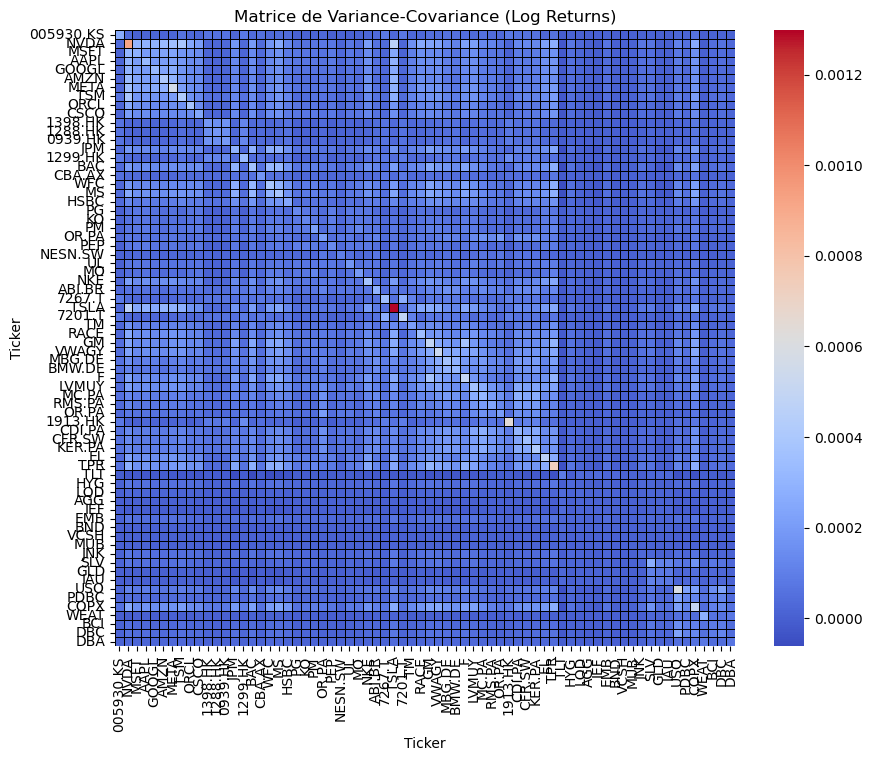

In [4]:
log_returns = processor.calculate_log_returns(price_data)

cov_matrix = log_returns.cov()

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix,
            cmap='coolwarm',
            annot=False,
            linewidths=0.5,
            linecolor='black',
            xticklabels=cov_matrix.columns,
            yticklabels=cov_matrix.index)

plt.title('Matrice de Variance-Covariance (Log Returns)')
plt.show()

In [5]:
benchmark = input("veuillez saisir votre benchmark")
all_assets = assets + [benchmark]

processor = DataProcessor(all_assets, start_date, end_date)
price_data = processor.download_data()
cleaned_data = processor.clean_data(price_data)

log_returns = processor.calculate_log_returns(cleaned_data)

log_returns_assets = log_returns[assets]
log_returns_benchmark = log_returns[benchmark]

cov_matrix = log_returns_assets.cov() * 252

cov_matrix

[*********************100%***********************]  70 of 70 completed


Ticker,005930.KS,NVDA,MSFT,AAPL,GOOGL,AMZN,META,TSM,ORCL,CSCO,...,SLV,GLD,IAU,USO,PDBC,COPX,WEAT,BCI,DBC,DBA
Ticker,,,,,,,,,,,,,,,,,,,,,
005930.KS,0.066768,0.009411,0.002915,0.005861,0.005627,0.003774,0.005504,0.015682,0.006233,0.004942,...,0.004106,0.000575,0.000522,0.004803,0.004222,0.014343,0.000251,0.001881,0.003865,0.002772
NVDA,0.009411,0.231037,0.078033,0.074081,0.073140,0.082183,0.088225,0.096949,0.062396,0.051680,...,0.017526,0.001482,0.001328,0.027337,0.013797,0.064201,-0.000813,0.009515,0.014815,0.007360
MSFT,0.002915,0.078033,0.070150,0.051143,0.053124,0.057441,0.058794,0.045132,0.041383,0.037040,...,0.011678,0.000890,0.000849,0.020252,0.009250,0.038545,0.000840,0.006443,0.010294,0.005641
AAPL,0.005861,0.074081,0.051143,0.081564,0.048969,0.052473,0.056227,0.046783,0.035746,0.037492,...,0.012766,0.001300,0.001330,0.023126,0.010620,0.042263,0.001219,0.006667,0.011435,0.005659
GOOGL,0.005627,0.073140,0.053124,0.048969,0.080465,0.058768,0.065930,0.044321,0.035150,0.033580,...,0.012086,0.001311,0.001306,0.018371,0.008531,0.038788,-0.000205,0.006414,0.009731,0.005176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COPX,0.014343,0.064201,0.038545,0.042263,0.038788,0.039507,0.043001,0.052142,0.037272,0.035475,...,0.042613,0.013152,0.013186,0.054738,0.031125,0.123840,0.010284,0.021157,0.032028,0.014784
WEAT,0.000251,-0.000813,0.000840,0.001219,-0.000205,-0.000404,0.000596,0.000205,-0.000359,0.002105,...,0.006490,0.003284,0.003284,0.013596,0.014313,0.010284,0.068849,0.012930,0.014762,0.018379
BCI,0.001881,0.009515,0.006443,0.006667,0.006414,0.006459,0.006367,0.009314,0.005568,0.005407,...,0.014778,0.006349,0.006390,0.030072,0.017937,0.021157,0.012930,0.018398,0.017988,0.008297


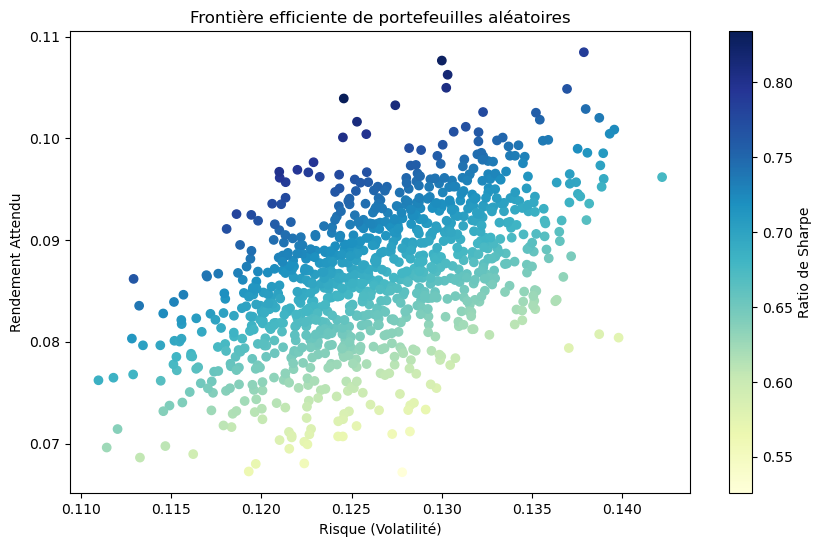

In [6]:
class PortfolioOptimization:
    def __init__(self, log_returns_assets, log_returns_benchmark, benchmark_weight=0.05):
        self.log_returns = log_returns_assets
        self.benchmark_returns = log_returns_benchmark
        self.mean_returns = log_returns_assets.mean() * 252
        self.cov_matrix = log_returns_assets.cov() * 252
        self.benchmark_weight = benchmark_weight
        self.allowed_shorts = ['HYG', 'TLT','GLD']

        self.sector_indices = range(len(sectors))
        self.bond_indices = range(len(sectors), len(sectors) + len(bonds))
        self.commodity_indices = range(len(sectors) + len(bonds), len(sectors) + len(bonds) + len(commodities))

        self.sector_tech_indices = range(0, len(sectors["Technologie"]))
        self.sector_finance_indices = range(len(sectors["Technologie"]), len(sectors["Technologie"]) + len(sectors["Finance-Banque"]))
        self.sector_biens_consommation_indices = range(len(sectors["Technologie"]) + len(sectors["Finance-Banque"]), len(sectors["Technologie"]) + len(sectors["Finance-Banque"]) + len(sectors["Biens de consommation"]))
        self.sector_automobile_indices = range(len(sectors["Technologie"]) + len(sectors["Finance-Banque"]) + len(sectors["Biens de consommation"]), len(sectors["Technologie"]) + len(sectors["Finance-Banque"]) + len(sectors["Biens de consommation"]) + len(sectors["Automobile"]))
        self.sector_luxe_indices = range(len(sectors["Technologie"]) + len(sectors["Finance-Banque"]) + len(sectors["Biens de consommation"]) + len(sectors["Automobile"]), len(sectors["Technologie"]) + len(sectors["Finance-Banque"]) + len(sectors["Biens de consommation"]) + len(sectors["Automobile"]) + len(sectors["Luxe"]))

    def sharpe_ratio_with_tracking_error(self, weights, risk_free_rate=0.02):
        portfolio_return = np.dot(weights, self.mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))

        portfolio_excess_returns = np.dot(self.log_returns, weights) - self.benchmark_returns
        tracking_error = np.std(portfolio_excess_returns) * np.sqrt(252)

        return - (portfolio_return - risk_free_rate) / portfolio_volatility + self.benchmark_weight * tracking_error

    def optimize_portfolio(self):
        num_assets = len(self.mean_returns)
        initial_weights = np.ones(num_assets) / num_assets

        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.sum(w[self.sector_indices]) - 0.60},
            {'type': 'eq', 'fun': lambda w: np.sum(w[self.bond_indices]) - 0.30},
            {'type': 'eq', 'fun': lambda w: np.sum(w[self.commodity_indices]) - 0.10},
            {'type': 'ineq', 'fun': lambda w: np.sum(w[self.sector_tech_indices]) - 0.09},
            {'type': 'ineq', 'fun': lambda w: np.sum(w[self.sector_finance_indices]) - 0.09},
            {'type': 'ineq', 'fun': lambda w: np.sum(w[self.sector_biens_consommation_indices]) - 0.09},
            {'type': 'ineq', 'fun': lambda w: np.sum(w[self.sector_automobile_indices]) - 0.09},
            {'type': 'ineq', 'fun': lambda w: np.sum(w[self.sector_luxe_indices]) - 0.09},
            {'type': 'ineq', 'fun': lambda w: 0.30 - np.sqrt(np.dot(w.T, np.dot(self.cov_matrix, w)))},
        ]
        bounds = []

        for ticker in self.log_returns.columns:
         if ticker in self.allowed_shorts:
          bounds.append((-0.06, 1.0))
         else:
          bounds.append((0.0, 1.0))

        result = minimize(self.sharpe_ratio_with_tracking_error, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x
        else:
            raise ValueError("L'optimisation a échoué.")

optimizer = PortfolioOptimization(log_returns_assets, log_returns_benchmark)
optimal_weights = optimizer.optimize_portfolio()


def efficient_frontier(mean_returns, cov_matrix, num_portfolios=1000):
    results = np.zeros((3, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)

        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        portfolio_sharpe = portfolio_return / portfolio_volatility

        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = portfolio_sharpe

    return results

results = efficient_frontier(optimizer.mean_returns, optimizer.cov_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.title("Frontière efficiente de portefeuilles aléatoires")
plt.xlabel("Risque (Volatilité)")
plt.ylabel("Rendement Attendu")
plt.colorbar(label="Ratio de Sharpe")
plt.show()

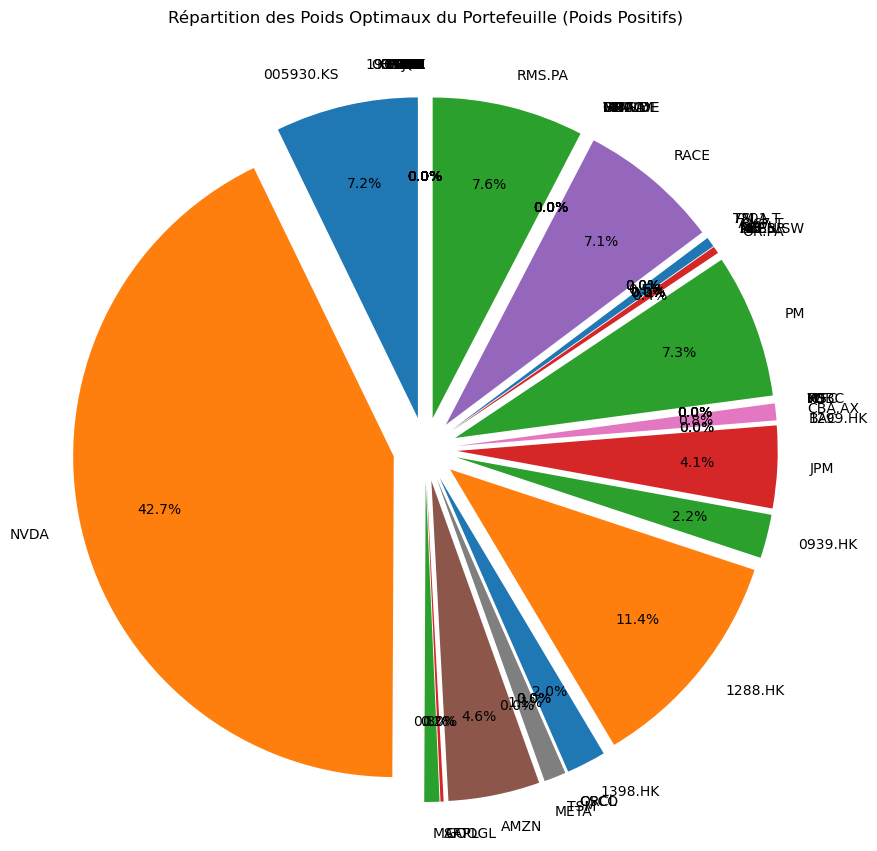


Actifs avec des poids négatifs (Vente à découvert) :
- TLT : -6.00%
- HYG : -6.00%
- GLD : -6.00%


In [7]:
positive_weights = optimal_weights[optimal_weights >= 0]
negative_weights = optimal_weights[optimal_weights < 0]

positive_tickers = log_returns_assets.columns[optimal_weights >= 0]
negative_tickers = log_returns_assets.columns[optimal_weights < 0]

optimal_weights_df = pd.DataFrame(positive_weights, index=positive_tickers, columns=["Poids optimaux"])

plt.figure(figsize=(10, 10))
explode = [0.1 for _ in range(len(positive_weights))]

plt.pie(optimal_weights_df["Poids optimaux"],
        labels=optimal_weights_df.index,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        pctdistance=0.75,
        labeldistance=1.1)

plt.title("Répartition des Poids Optimaux du Portefeuille (Poids Positifs)", pad=30)
plt.axis('equal')
plt.show()

if len(negative_tickers) > 0:
    print("\nActifs avec des poids négatifs (Vente à découvert) :")
    for ticker, weight in zip(negative_tickers, negative_weights):
        print(f"- {ticker} : {weight * 100:.2f}%")

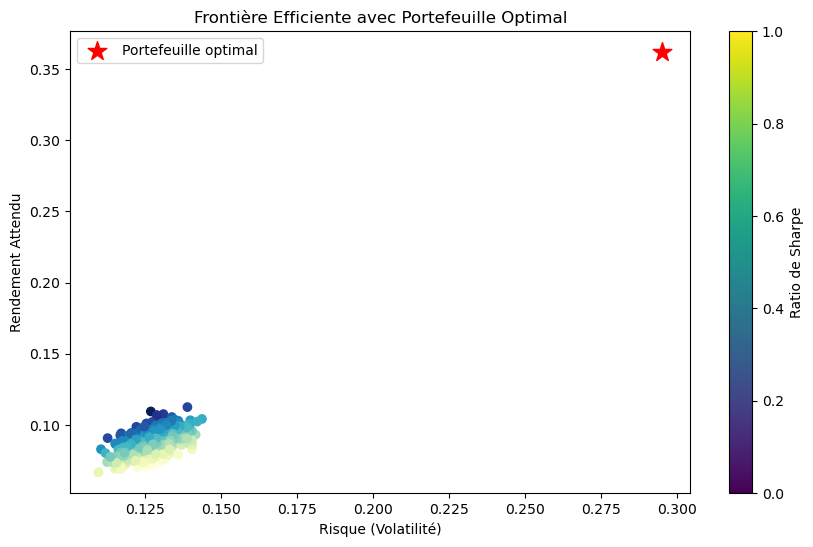

In [8]:
results = efficient_frontier(optimizer.mean_returns, optimizer.cov_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o')

optimal_return = np.dot(optimal_weights, optimizer.mean_returns)
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(optimizer.cov_matrix, optimal_weights)))
plt.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=200, label="Portefeuille optimal")

plt.title("Frontière Efficiente avec Portefeuille Optimal")
plt.xlabel("Risque (Volatilité)")
plt.ylabel("Rendement Attendu")
plt.colorbar(label="Ratio de Sharpe")
plt.legend(loc="upper left")
plt.show()

## Partie 3 : Backtesting et Analyse de Performance

In [9]:
class Backtest:
    def __init__(self, price_data, log_returns, benchmark_returns, rebalance_period='ME', end_date=None):
        self.price_data = price_data
        self.log_returns = log_returns
        self.benchmark_returns = benchmark_returns
        self.rebalance_period = rebalance_period
        self.portfolio_value = 1  # Démarre avec 1 (100%)
        self.history = []
        self.end_date = end_date if end_date else price_data.index[-1]

    def run(self):
        """Effectue le backtest avec réallocation trimestrielle sur les 10 dernières années + lookback."""
        lookback = 126  # 6 mois ~ 126 jours ouvrés
        start_date = pd.to_datetime(self.end_date) - pd.DateOffset(years=11)

        filtered_data = self.price_data.loc[start_date:self.end_date]
        filtered_log_returns = self.log_returns.loc[start_date:self.end_date]
        filtered_benchmark_returns = self.benchmark_returns.loc[start_date:self.end_date]

        # Rééquilibrage trimestriel
        rebalance_dates = filtered_data.resample('Q').first().index
        weights_prev = np.zeros(len(self.log_returns.columns))

        for date in rebalance_dates:
            try:
                idx = filtered_log_returns.index.get_indexer([date], method='backfill')[0]
            except:
                continue  

            if idx < lookback:
                continue  

            past_returns = filtered_log_returns.iloc[idx - lookback:idx]
            past_benchmark = filtered_benchmark_returns.iloc[idx - lookback:idx]

            optimizer = PortfolioOptimization(past_returns, past_benchmark)

            try:
                weights = optimizer.optimize_portfolio()
            except ValueError:
                print(f"Optimisation échouée pour la date {date}.")
                continue

            next_period_returns = filtered_log_returns.iloc[idx:idx + 21]
            if next_period_returns.empty:
                continue

            portfolio_returns = (next_period_returns @ weights).cumsum()
            gross_return = 1 + portfolio_returns.iloc[-1]

            self.portfolio_value *= gross_return
            self.history.append((date, self.portfolio_value))
            weights_prev = weights.copy()

        return pd.DataFrame(self.history, columns=['Date', 'Portfolio Value']).set_index('Date')

    def get_optimal_weights(self, target_date):
        if target_date not in self.price_data.index:
            raise ValueError(f"La date {target_date} n'est pas disponible dans les données.")

        past_returns = self.log_returns[:target_date]
        if len(past_returns) < 60:
            raise ValueError(f"Pas assez de données pour optimiser à la date {target_date}.")

        optimizer = PortfolioOptimization(past_returns, self.benchmark_returns[:target_date])
        try:
            weights = optimizer.optimize_portfolio()
            return pd.Series(weights, index=self.log_returns.columns, name="Poids optimaux")
        except ValueError:
            raise ValueError(f"Optimisation échouée pour la date {target_date}.")


end_date = datetime.today().strftime('%Y-%m-%d')
backtest = Backtest(cleaned_data, log_returns_assets, log_returns_benchmark, end_date=end_date)
portfolio_performance = backtest.run()

portfolio_performance['Cumulative Return'] = portfolio_performance['Portfolio Value'] / portfolio_performance['Portfolio Value'].iloc[0] - 1
portfolio_performance['Annualized Return'] = (1 + portfolio_performance['Cumulative Return']) ** (1/10) - 1

print(f"\nMétriques de performance à la date du {end_date}:")
print(f"Rendement cumulé : {portfolio_performance['Cumulative Return'].iloc[-1]:.2%}")
print(f"Rendement annualisé : {portfolio_performance['Annualized Return'].iloc[-1]:.2%}")


Métriques de performance à la date du 2025-10-03:
Rendement cumulé : 124.71%
Rendement annualisé : 8.43%


In [10]:
def get_optimal_weights_interactive(backtest):
    target_date = datetime.today().strftime('%Y-%m-%d')
    print(f"Répartition des Poids Optimaux du Portefeuille (Poids Positifs) à la date du : {target_date}")
    try:
        target_date = pd.to_datetime(target_date)
        optimal_weights = backtest.get_optimal_weights(target_date)

        positive_weights = optimal_weights[optimal_weights >= 0]
        negative_weights = optimal_weights[optimal_weights < 0]

        if len(positive_weights) > 0:
            explode = [0.1 for _ in range(len(positive_weights))]
            plt.figure(figsize=(10, 10))
            plt.pie(positive_weights, labels=positive_weights.index, autopct='%1.1f%%', startangle=90, explode=explode, pctdistance=0.75, labeldistance=1.1)
            plt.title("Répartition des Poids Optimaux du Portefeuille (Poids Positifs)", pad=30)
            plt.axis('equal')
            plt.show()

        if len(negative_weights) > 0:
            print("\nActifs avec des poids négatifs (Vente à découvert) :")
            for ticker, weight in zip(negative_weights.index, negative_weights):
                print(f"- {ticker} : {weight * 100:.2f}%")

    except Exception as e:
        print(f"Erreur : {e}")

get_optimal_weights_interactive(backtest)

Répartition des Poids Optimaux du Portefeuille (Poids Positifs) à la date du : 2025-10-03
Erreur : La date 2025-10-03 00:00:00 n'est pas disponible dans les données.


[*********************100%***********************]  1 of 1 completed


Performance Annualisée du Portefeuille : 0.08433115775974631
Performance Annualisée du Benchmark : Ticker
AOR    0.073005
Name: 2025-10-02 00:00:00, dtype: float64


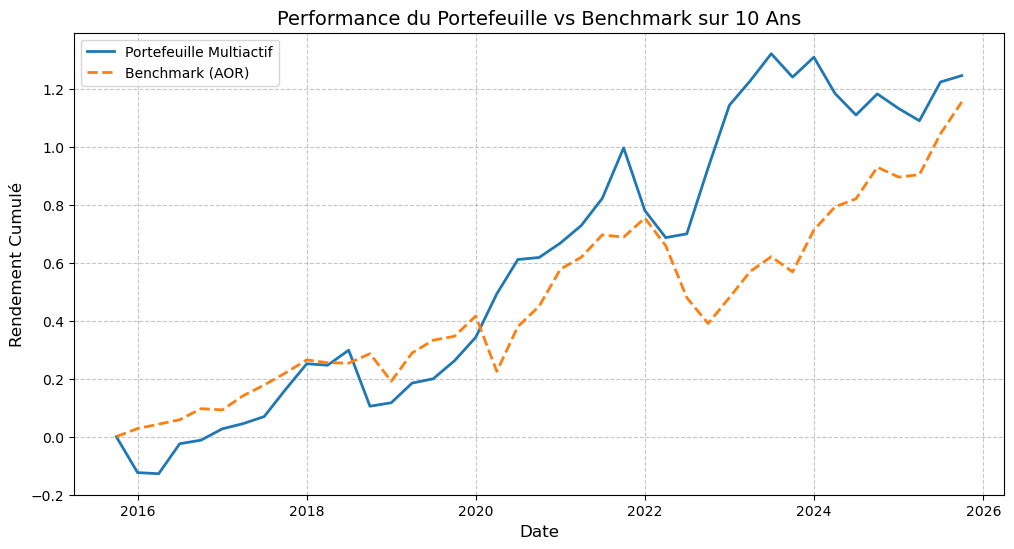


Rendements annualisés par année :
2016     17.26%
2017     21.89%
2018    -10.76%
2019     20.24%
2020     24.24%
2021      6.70%
2022     20.45%
2023      7.74%
2024     -7.67%
2025      5.32%
Name: Annual Return, dtype: object


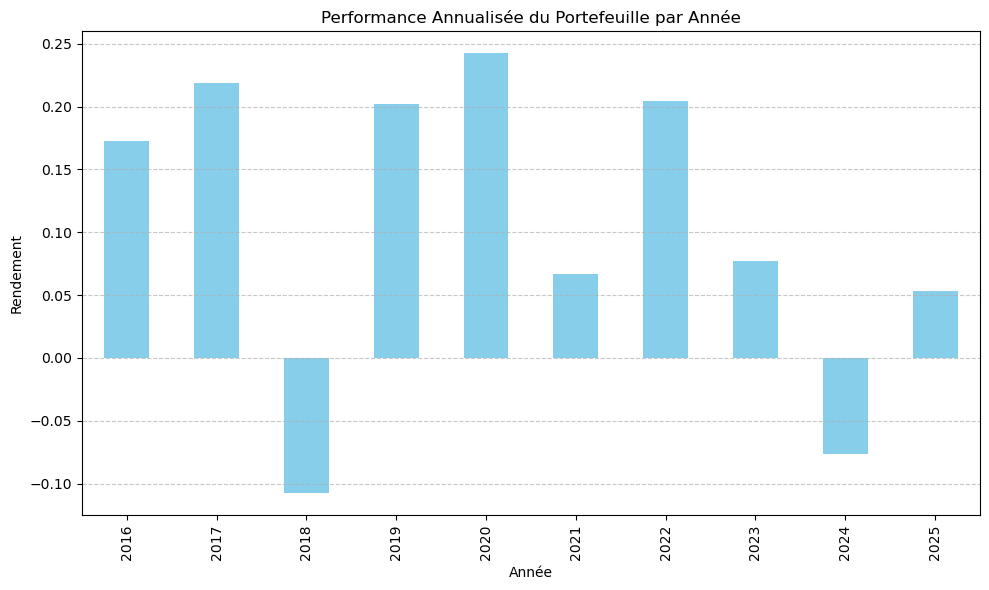

❌ Erreur : La date 2025-10-03 n'est pas disponible dans les données.


In [11]:
benchmark_data = yf.download(benchmark, start=start_date, end=end_date)['Close']
benchmark_data = benchmark_data.ffill().bfill()

benchmark_returns = benchmark_data.pct_change().dropna()
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()
benchmark_annualized_return = (benchmark_cumulative_returns.iloc[-1] ** (1/10)) - 1

portfolio_performance['Benchmark Value'] = benchmark_cumulative_returns.reindex(portfolio_performance.index, method='ffill')
portfolio_performance['Benchmark Cumulative Return'] = portfolio_performance['Benchmark Value'] / portfolio_performance['Benchmark Value'].iloc[0] - 1

print("Performance Annualisée du Portefeuille :", portfolio_performance['Annualized Return'].iloc[-1])
print("Performance Annualisée du Benchmark :", benchmark_annualized_return)

plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Cumulative Return'], label='Portefeuille Multiactif', linewidth=2)
plt.plot(portfolio_performance.index, portfolio_performance['Benchmark Cumulative Return'], label=f'Benchmark ({benchmark})', linestyle='--', linewidth=2)
plt.title("Performance du Portefeuille vs Benchmark sur 10 Ans", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Rendement Cumulé", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

def compute_annual_returns(performance_df):
    annual_returns = {}
    grouped = performance_df['Portfolio Value'].resample('Y').last()
    for i in range(1, len(grouped)):
        year = grouped.index[i].year
        start_value = grouped.iloc[i - 1]
        end_value = grouped.iloc[i]
        annual_return = (end_value / start_value) - 1
        annual_returns[year] = annual_return
    return pd.Series(annual_returns, name="Annual Return")

portfolio_performance.index = pd.to_datetime(portfolio_performance.index)

annual_returns = compute_annual_returns(portfolio_performance)

print("\nRendements annualisés par année :")
print(annual_returns.apply(lambda x: f"{x:.2%}"))

plt.figure(figsize=(10, 6))
annual_returns.plot(kind='bar', color='skyblue')
plt.title("Performance Annualisée du Portefeuille par Année")
plt.xlabel("Année")
plt.ylabel("Rendement")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

target_date = datetime.today().strftime('%Y-%m-%d')


try:
    weights_series = backtest.get_optimal_weights(target_date)

    weights_list = [(ticker, round(weight, 4)) for ticker, weight in weights_series.items() if abs(weight) > 1e-6]

    print(f"\n📊 Poids optimaux au {target_date} (actifs non-nuls) :")
    for ticker, weight in weights_list:
        print(f"{ticker} : {weight:.4f}")

    weights_only = [weight for _, weight in weights_list]
    tickers_only = [ticker for ticker, _ in weights_list]

except ValueError as e:
    print(f"❌ Erreur : {e}")